<a href="https://colab.research.google.com/github/roschly/where-my-south-park-gone/blob/master/ProjectB_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
import requests
import numpy as np
import networkx as nx
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
import urllib
import os
from collections import Counter
import itertools

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = "/content/gdrive/My Drive/Colab Notebooks/Social Graphs/"
media_path = root_path + "/media/"
data_path = root_path + "/data/"
script_path = data_path + "scripts/"

# The full network across all South Park seasons

## Load csv episode guide (season, episode, title)

In [0]:
df_episodes = pd.read_csv(data_path + "season_episode_title.csv", sep='|')
df_episodes.loc[df_episodes["season"] == 9]

season  episode                                   title
125       9        1         Mr. Garrison's Fancy New Vagina
126       9        2                         Die Hippie, Die
127       9        3                                    Wing
128       9        4                    Best Friends Forever
129       9        5                         The Losing Edge
130       9        6               The Death of Eric Cartman
131       9        7                            Erection Day
132       9        8  Two Days Before the Day After Tomorrow
133       9        9                               Marjorine
134       9       10                        Follow That Egg!
135       9       11                             Ginger Kids
136       9       12                   Trapped in the Closet
137       9       13                            Free Willzyx
138       9       14                             Bloody Mary

## Download script data & save to disk

In [0]:
i = 0
for d in df_episodes.iterrows():
    i += 1
    print(i)
    
    # season 9 has a different markup than the rest
    if d[1]["season"] == 9:
        pass
    
    # get full script page
    title = d[1]["title"]
    title_url_enc = urllib.parse.quote(title)
    script_text = requests.get("http://southpark.wikia.com/wiki/" + title_url_enc + "/Script?action=raw").text
    
    # Filter: only keep script lines (ScriptScene or ScriptDialog)
    # And get rid of encapslulation "{{ ... }}"
    pattern = "{{((?:ScriptScene|ScriptDialog).*)}}"
    script_lines = re.findall(pattern, script_text)
    
    # Remove description in dialog (no actual words spoken)
    for j, line in enumerate(script_lines):
        script_lines[j] = re.sub("''\[.*?\]''", "", line)
    
    # write each line to file
    filename = str(d[1]["season"]) + "_" + str(d[1]["episode"]) + '.txt'
    with open(script_path + filename, 'w+') as f:
        for line in script_lines:
            f.write(line + '\n')
    

### Season 9 has a different markup style than the other seasons
So handle that season on it's own

In [0]:
# EXAMPLE: format of season 9 episodes
# | bgcolor="#{{Color3}}"|''[Trinidad Medical Center, day. A very modern, futuristic-looking building is seen behind the sign. Inside, a doctor approaches a patient]''
# |-
# !Doctor:
# |Hello, Mr. Garrison, I'm Dr. Biber. I'll be performing your surgery today.
# |-
# !Mr. Garrison:
# |''[on the hospital bed, his legs in stirrups]'' God bless you, Doctor. I know you'll make me well again.
# |-
# !Dr. Biber:
# |Now, you're absolutely sure you want a vaginoplasty?
# |-

# 1st part looks for ScriptScenes
# 2nd part looks for ScriptDialoges
# it's a very non-readable regex, but it works for the formatting
# Why use one regex instead of two? Because it keeps the line order, which is important
re_pattern = "\|.*?\|''\[(.*)\]''|\n!(.*):\n\|(.*)"

In [0]:
season9 = df.loc[df['season'] == 9]

i = 0
for d in season9.iterrows():
    i += 1
    print(i)
    
    # get full script page
    title = d[1]["title"]
    title_url_enc = urllib.parse.quote(title)
    script_text = requests.get("http://southpark.wikia.com/wiki/" + title_url_enc + "/Script?action=raw").text
    
    script_lines_wrong_format = re.findall(re_pattern, script_text)
    script_lines = []
    for line in script_lines_wrong_format:
        if line[0] != '': # ScriptScene
            script_lines.append("ScriptScene|" + line[0] )
        else:             # ScriptDialog
            # Remove descriptions in dialog (no actual words spoken)
            script_lines.append("ScriptDialog|" + line[1] + "|" + re.sub("''\[.*?\]''", "", line[2]) )
    
    # write each line to file
    filename = str(d[1]["season"]) + "_" + str(d[1]["episode"]) + '.txt'
    with open(script_path + filename, 'w+') as f:
        for line in script_lines:
            f.write(line + '\n')


## Download synopses data & keep in memory

In [0]:
# key: season nr, value: [episode synopses]
season_synopses = []

for d in df_episodes.iterrows():
    # get episode synopsis
    title = d[1]["title"]
    title_url_enc = urllib.parse.quote(title)
    script_text = requests.get("http://southpark.wikia.com/wiki/" + title_url_enc + "?action=raw").text
    
    # Find text in synopsis
    pattern = "==[ ]?Synopsis[ ]?==\n(.*)\n"
    synopsis = re.findall(pattern, script_text)[0]
    
    # find and replace links in synopis
    pattern = "\[\[(.*?)\]\]"
    links = re.findall(pattern, synopsis)
    for link in links:
        split_link = link.split("|")
        name = split_link[0] if len(split_link) == 1 else split_link[-1]
        # replace the link in text with the name
        synopsis = synopsis.replace("[[" + link + "]]", name)
    
    season_synopses.append( (d[1]['season'], synopsis) )
    
df_synopses = pd.DataFrame(season_synopses, columns=['season', 'synopsis'])
df_synopses.head()

season                                           synopsis
0       1  While the boys are waiting for the school bus,...
1       1  Cartman "wins" an essay contest and Kathie Lee...
2       1  The boys go on a hunting trip with Stan Marsh'...
3       1  Stan's new dog, Sparky, comes across as potent...
4       1  Kyle's mom won't let him keep his new pet, an ...

## Read script files and find characters and dialog

In [0]:
season_char_dialog = []

# In each script file, find characters and their dialog
for filename in os.listdir(script_path):
    season = int(filename.split("_")[0]) # '9_3.txt' ==> 9
    with open(script_path + filename, 'r') as f:
        script_text = f.read()

    pattern = "ScriptDialog\|(.*?)\|(.*?)\\n"
    script_chars_and_dialog = re.findall(pattern, script_text)
    # remove dialog with missing character name
    script_chars_and_dialog = [x for x in script_chars_and_dialog if x[0] != '']

    for char, dialog in script_chars_and_dialog:
        season_char_dialog.append( (season, char, dialog) )

# Create dataframe
df_dialog = pd.DataFrame(
    season_char_dialog,
    columns=['season', 'character', 'dialog']
)
df_dialog.head()

season        character                                             dialog
0       1             Boys  ''School day, school day, teacher's golden ru....
1       1  Kyle Broflovski  Ah, damn it! My little brother's trying to fol...
2       1   Ike Broflovski                                        Zeeponaner.
3       1             Kyle            Ike, you can't come to school with me. 
4       1     Eric Cartman                    Yeah, go home you little dildo!

### Top 10 characters based on dialog lines

In [0]:
df_dialog.character.value_counts()[:10]

Cartman         10639
Stan             7967
Kyle             7534
Randy            2951
Butters          2858
Mr. Garrison     1160
Chef              949
Gerald            933
Sharon            932
Kenny             930
Name: character, dtype: int64

3 characters stand out from the rest: Cartman, Stan and Kyle.  
They have been the main characters from the pilot episode, so it shouldn't be a surprise.  
Kenny is one of the original 4 as well, but appears below many of the other supporting cast.  
This can be explained by 3 different factors:
- Kenny's voice is muffled by his hood which is almost always covering his mouth. This limits the amount of dialog he is given.
- Killing Kenny in every episode was a gimmick in the first seasons.
- After the creators of South Park got tired of coming up with new ways to kill Kenny in every episode, they sidetracked him for quite a few seasons, before bringing him back again (this time without constantly killing him).

### FInding the important characters in the scripts

In [0]:
char_occur = df_dialog.character.value_counts()

print('Total number of characters in the scripts:')
print( len(char_occur) )

print("Number of characters with 10 or fewer lines:")
less_10 = len([c for c in char_occur if c < 10])
print("{0} ({1} %)".format(less_10, int(less_10/len(char_occur)*100) ))

Total number of characters in the scripts:
4387
Number of characters with 10 or fewer lines:
3607 (82 %)


This is way too many characters for all of them to be significant to the show. Many of them are generic ones, there are ambiguities between episodes (e.g. different characters with the same first name) and typos in the script.
This is clearly shown by the fact that a vast majority of the characters have 10 or fewer lines in all the seasons *combined*.

In [0]:
N = 100 # number of significant characters
dialog_mass = sum( char_occur.tolist()[:N] ) / sum( char_occur.tolist() )
print("The {0} most significant characters account for {1} % of all dialog.".format( N, np.round(dialog_mass,2) * 100) )

print("They have at least {0} lines of dialog across 21 seasons, equivalent to {1} line(s) of dialog per episode.".format(char_occur[N], np.round(char_occur[N]/len(df_episodes.index,),2) ) )

The 100 most significant characters account for 70.0 % of all dialog.
They have at least 70 lines of dialog across 21 seasons, equivalent to 0.24 line(s) of dialog per episode.


Focusing on the 100 most significant characters based on dialog lines, seems like a good cutoff point.

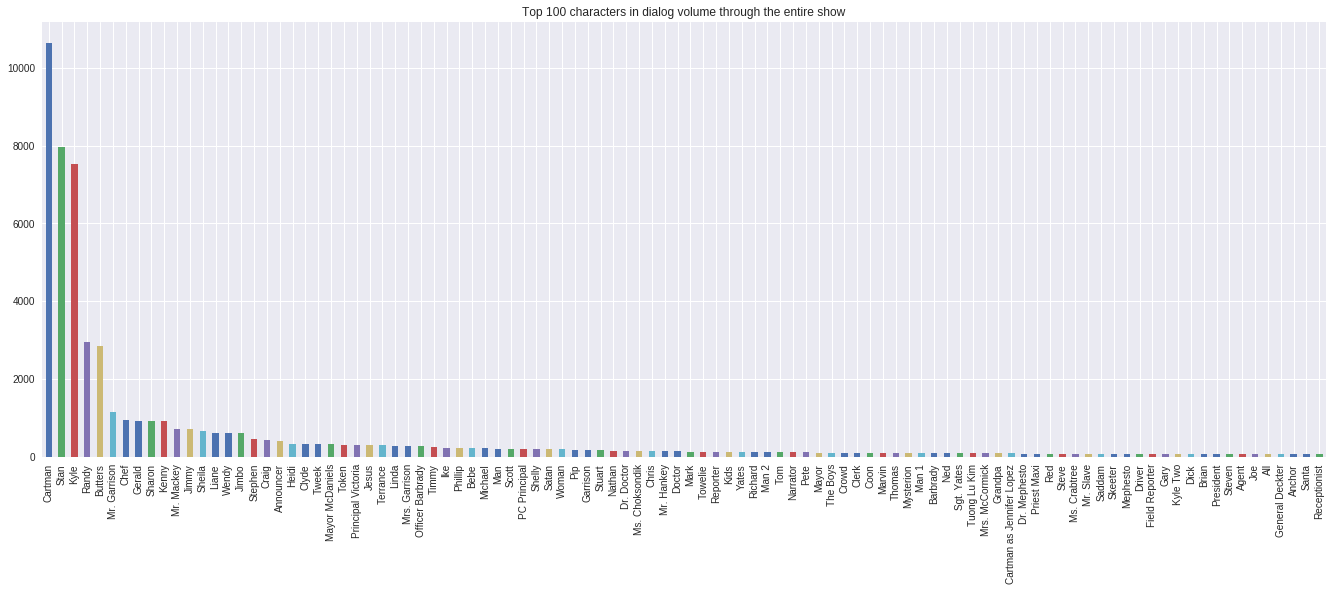

In [0]:
top_X = 100
plt.figure(figsize=(23,8))
# plt.figure(figsize=(10,5))
char_occur[:top_X].plot(kind='bar', rot=90)
plt.title('Top {0} characters in dialog volume through the entire show'.format(top_X))
# plt.savefig(media_path + 'dialog volume top 10.png')
plt.show()

Even among the 100 most significant ones, there are some generic characters in the mix.  
E.g.: Announcer, Man, Man 1, Man 2, Woman, Narrator, The Boys  

This is unavoidable, since the transcripts focus on differentiating the individual characters *within* each episode and not across *all* episodes and seasons. So an anonymous man with a single line, will simply be labeled as "Man" or similar.

The more generic and ambiguous characters, the less representative the interactions of the real characters overall become. So keeping them to a minimum is necessary.

In [0]:
# Only keep dialog from the 100 most significant characters
top100names = char_occur[:100].index.tolist()
df_dialog = df_dialog.loc[df_dialog['character'].isin( top100names )]

## The interaction network

The scripts consists of lines of either ScriptScene or ScriptDialog.  
A ScriptScene is taken to mean a new scene.  
A ScriptDialog is simply a line of dialog in the current scene.

Caveat: some ScriptScene lines are more like scene descriptions, where the actual "physical" scene doesn't change. However it is beyond the scope of this project to differentiate between the two.  
So some scenes are not actual scenes at all, but averaged over 21 seasons I think it is a fair enough approximation.

In [0]:
current_scene = set()
season_scenes = {} # all scenes in a season

for filename in os.listdir(script_path):
    season = int(filename.split("_")[0])
    with open(script_path + filename, 'r') as f:
        text = f.read()
    script_lines = text.split("\n")

    # if ScriptScene: save current scene to scenes AND start new empty scene
    # if ScriptDialog: add character to current scene
    for line in script_lines:
        line_split = line.split("|")
        if line_split[0] == "ScriptScene":
            try:
                season_scenes[season].append(current_scene)
            except:
                season_scenes[season] = [current_scene]
            current_scene = set()
        elif line_split[0] == "ScriptDialog":
            character = line_split[1]
            if character in top100names: # filter out the non significant chars
                current_scene.add(character)

### Filter out scenes with 0 or 1 character (no interaction going on)

In [0]:
# remove all scenes with 0 or 1 characters (no interactions going on)
for season in range(1,21+1):
    season_scenes[season] = [ s for s in season_scenes[season] if len(s) > 1 ]

### Calculate interactions based on character occurrences in scenes
Every scene is a set of characters that appear in the scene.  
Interactions are all the possible combinations of characters in a set.  
Example: {Cartman, Kyle, Stan} ==> (Cartman, Kyle), (Cartman, Stan), (Kyle, Stan)

Notice: the number of dialog lines in each scene is irrelevant for this measure of interaction. Only the presence in a scene matters.  
I think this is a fair definition of interaction, since some characters simply speak more than others and since we can't interpret the content of the dialog, we don't know if the dialog was aimed at someone, who might or might not respond.

In [0]:
seasons = []
all_interactions = []

# For every scene (set of chatacters) in every season:
# Create all combinations of size 2 from characters in the scene
for season in range(1,21+1):
    for scene in season_scenes[season]:
        # make sure to sort characters first, so that any link between two 
        # characters always has the same order of characters
        interactions = itertools.combinations( sorted(scene) , 2)
        for interact in interactions:
            all_interactions.append( tuple(sorted(interact)) )
            seasons.append(season)
        
df_interact = pd.DataFrame(
    {
        'season': seasons,
        'interaction': all_interactions
    }
)

df_interact.head()

interaction  season
0   (Cartman, Ike)       1
1  (Cartman, Kyle)       1
2  (Cartman, Stan)       1
3      (Ike, Kyle)       1
4      (Ike, Stan)       1

In [0]:
# Example
print('Number of interactions between Cartman and Stan:')
df_interact.interaction.value_counts()[ ('Cartman', 'Stan') ]

Number of interactions between Cartman and Stan:


1576

### Create network of interactions

In [0]:
# links and their weight
links = df_interact.interaction.value_counts().index.tolist()
weights = df_interact.interaction.value_counts().tolist()

# Undirected network
G = nx.Graph()

for i, link in enumerate(links):
    G.add_edge(link[0], link[1], weight=weights[i])
    
print("# nodes:", G.number_of_nodes())
print("# edges:", G.number_of_edges())
print("Sum of all edge weights:", sum([d[1] for d in G.degree(G.nodes, weight='weight')]))

# nodes: 100
# edges: 1972
Sum of all edge weights: 52720


### Two types of interaction measures
The interaction **strength** of a character, is how many interactions he has had in total with all other characters in the network.  
This is equivalent to the **weighted** degree of a node.

The interaction **reach** of a character, is how many different characters he has interacted with (for any number of times).  
This is equivalent to the **unweighted** degree of a node.

For a character to be central to the show, he must have a high interaction strength (lots of interactions) and reach (interactions with many different characters).

### Top 10 characters based on interaction strength

In [0]:
names, weights = zip(* G.degree(G.nodes(), weight='weight') )
_, unweights = zip(* G.degree(G.nodes()) )

char_weight_unweight = list(zip(names, weights, unweights))

df_interact_str = pd.DataFrame(char_weight_unweight, columns=['character', 'weighted', 'unweighted'])
df_interact_str.set_index('character', inplace=True)

df_interact_str.head()

weighted  unweighted
character                      
Kyle           7330          97
Stan           7700          95
Cartman        7357          95
Butters        2660          81
Kenny          1633          81

In [0]:
print('Top 10 interaction strength')
# df_interact_str.sort_values(by=['weighted'], ascending=False)[:10]
df_interact_str.weighted.sort_values(ascending=False)[:10]

Top 10 interaction strength


character
Stan            7700
Cartman         7357
Kyle            7330
Butters         2660
Randy           2245
Kenny           1633
Mr. Garrison    1106
Sharon          1074
Gerald          1054
Clyde            929
Name: weighted, dtype: int64

In [0]:
print('Top 10 dialog volume')
df_dialog.character.value_counts()[:10]

Top 10 dialog volume


Cartman         10639
Stan             7967
Kyle             7534
Randy            2951
Butters          2858
Mr. Garrison     1160
Chef              949
Gerald            933
Sharon            932
Kenny             930
Name: character, dtype: int64

The two top 10 (interactions vs dialog) share a lot of names, but the order is a bit different. Perhaps most noticeable, Stan and Cartman have swithced positions. So even though cartman has quite a few more dialog lines than Stan and Kyle,  Stan appears to be interacting more with other characters.

Kenny has also jumped a handful of places up the list, indicating that he is part of a lot of scenes despite what the inital dialog count indicates. This fits with the idea that Kenny was, and returned to be, one of the main characters of South Park.

### Distribution of interaction strengths

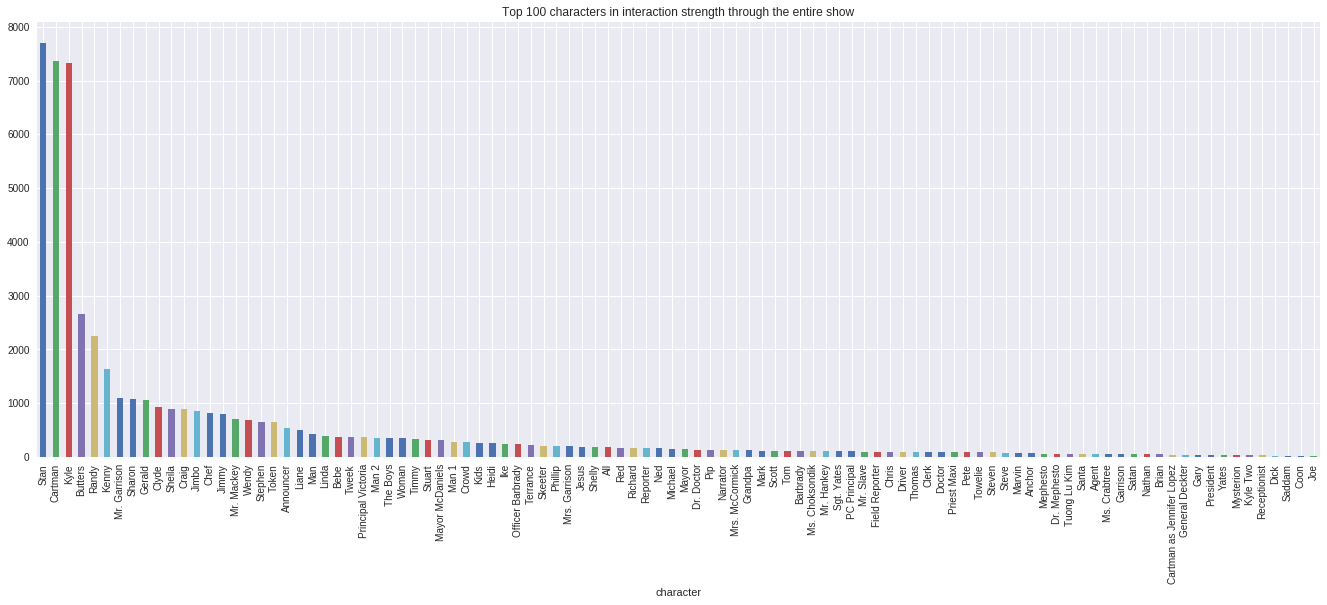

In [0]:
top_X = 100
plt.figure(figsize=(23,8))
df_interact_str.weighted.sort_values(ascending=False)[:top_X].plot(kind='bar', rot=90)
plt.title('Top {0} characters in interaction strength through the entire show'.format(top_X))
# plt.savefig(media_path + 'test.png', bbox_inches='tight', pad_inches=2, dpi=100)
plt.show()

The distribution has a similar shape as the dialog volume distribution. This means that the interaction strength of a character is proportional with his dialog volume. Ergo the vast majority of dialog in South Park is actual dialog (conversational exchange between multiple people) as opposed to monologs.

### Plot *weighted* degree distribution - interaction *strength*

Max: 7700
Min: 23


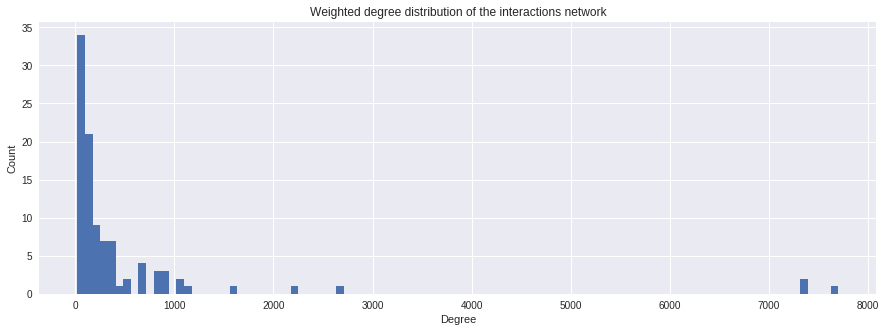

In [0]:
print('Max:', df_interact_str.weighted.max())
print('Min:', df_interact_str.weighted.min())

plt.figure(figsize=(15,5))
plt.hist(df_interact_str.weighted.values, bins=100)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Weighted degree distribution of the interactions network')
plt.show()

The weighted degree distribution follows a power-law distribution, known from social networks. This is not unexpected, since the show primarily depicts the interactions between a group of connected people - the town of South Park. 

### Plot *unweighted* degree distribution - interaction *reach*

Max: 97
Min: 3


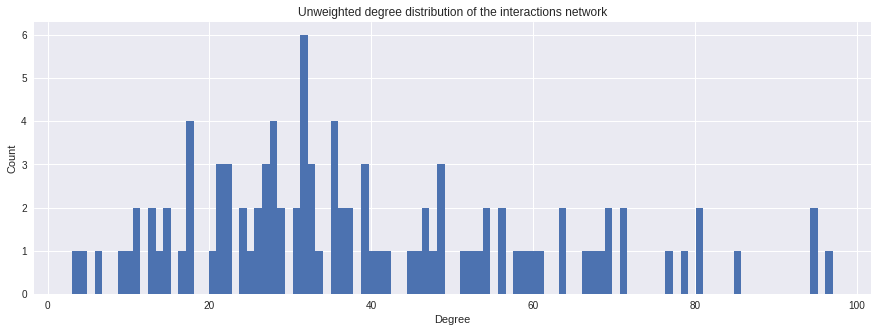

In [0]:
print('Max:', df_interact_str.unweighted.max())
print('Min:', df_interact_str.unweighted.min())

plt.figure(figsize=(15,5))
plt.hist(df_interact_str.unweighted.values, bins=100)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Unweighted degree distribution of the interactions network')
plt.show()

The unweighted degree distribution is a bit harder to categorize. It neither follows a random network distribution (right tail too long) nor a power-law distribution (too much mass around the center). 

A couple of plausible explanations for this distribution:
- I have kept only the top 100 characters (dialog volume), so a large amount of characters with very few interactions have already been filtered out. This is the main reason, since ca. 82 % of all characters had only 1 line of dialog, which would amount to 0 or a couple of interactions.
- Even among the top 100 there are outlier characters (generic, misspelled and ambiguous ones), that aren't real characters like the others.
- This is a TV show and not a real social network. It is possible that in the name of entertainment, some additional artificial constraints cause this distribution.


### Plot interaction network

In [0]:
!pip install fa2
from fa2 import ForceAtlas2

    100% |████████████████████████████████| 81kB 2.5MB/s 
  Running setup.py bdist_wheel for fa2 ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/39/c7/0c/a62ea06fc84864edeecf6f7501f3bebcf38f47dbedbe46187a
Successfully built fa2


In [0]:
forceatlas2 = ForceAtlas2(
                         # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=2.0,  # Tolerance
                          barnesHutOptimize=False,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=60.0, #1.0,

                          # Log
                          verbose=True)
pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:00<00:00, 6152.14it/s]

Repulsion forces  took  0.09  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


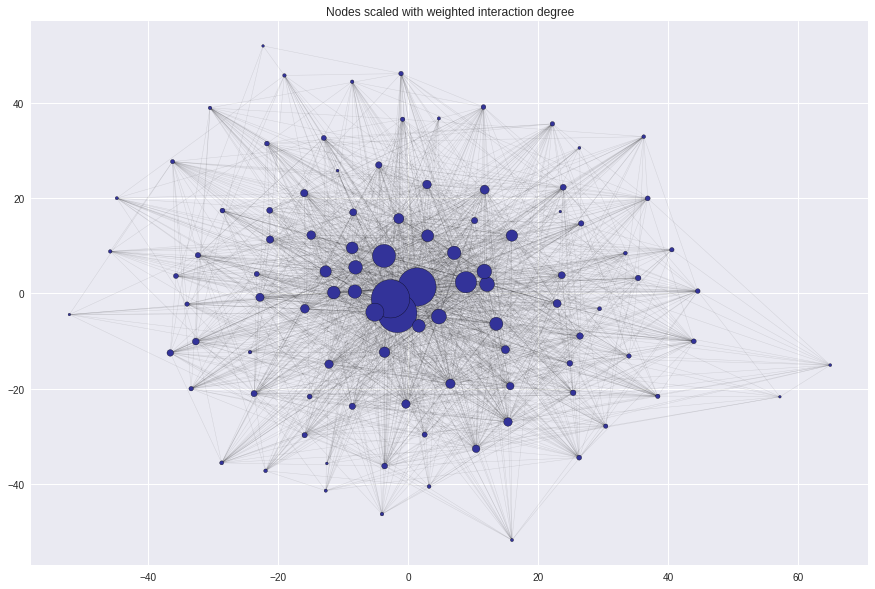

In [0]:
# Weighted interactions

plt.figure(figsize=(15,10))
# pos = nx.spring_layout(G)
scale_rate = 0.2

node_size = list(map(lambda n: 2+scale_rate*G.degree(n, weight="weight"), G.nodes()))
nx.draw_networkx_nodes(G, pos, with_labels=False, node_color="#333399", edgecolors="black", node_size=node_size )
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color="black", width=0.5)

plt.title('Nodes scaled with weighted interaction degree')
plt.show()

The 3 big ones in the middle are the main characters: Cartman, Stan, Kyle. The hub-like nature of these 3 are pretty clear from their huge sizes. A handful of hubs dominate this network.

### The un-weighted interaction network

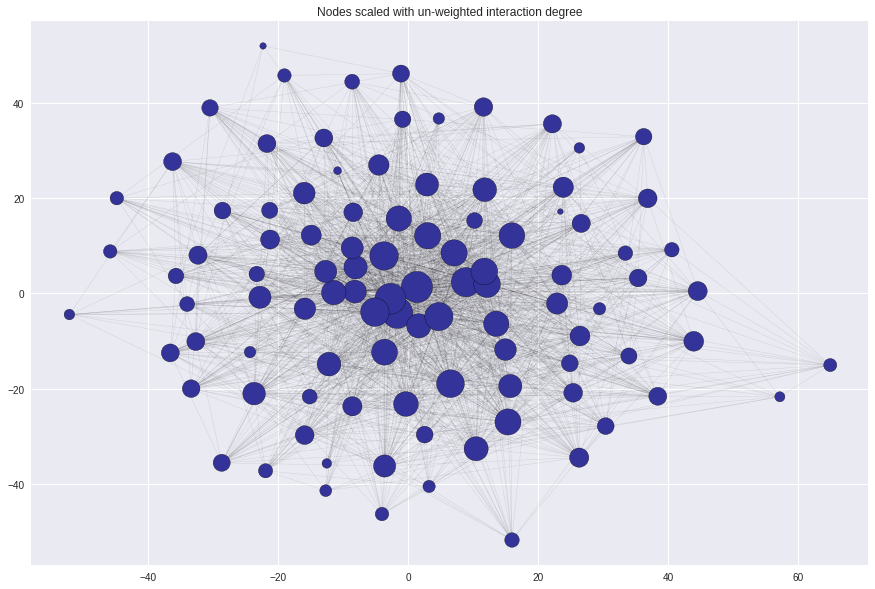

In [0]:
plt.figure(figsize=(15,10))
# pos = nx.spring_layout(G)
scale_rate = 10

node_size = list(map(lambda n: 2+scale_rate*G.degree(n), G.nodes()))
nx.draw_networkx_nodes(G, pos, with_labels=False, node_color="#333399", edgecolors="black", node_size=node_size )
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color="black", width=0.5)

plt.title('Nodes scaled with un-weighted interaction degree')
plt.show()

The central mass of the unweighted distribution plot shown earlier, is visible in this plot. There are a few small ones, and a few a bit bigger than the others, but the most nodes appear to be very close to the average size. This indicates that this is a highly connected network.

In [0]:
print("Is the graph connected (no isolated nodes)?")
nx.connected.is_connected(G)

Is the graph connected (no isolated nodes)?


True

In [0]:
print("The top 3 connected characters:")
df_interact_str.unweighted.sort_values(ascending=False)[:3]

The top 3 connected characters:


character
Kyle       97
Stan       95
Cartman    95
Name: unweighted, dtype: int64

The 3 main characters are almost connected to every other character.

## Eigenvector centrality

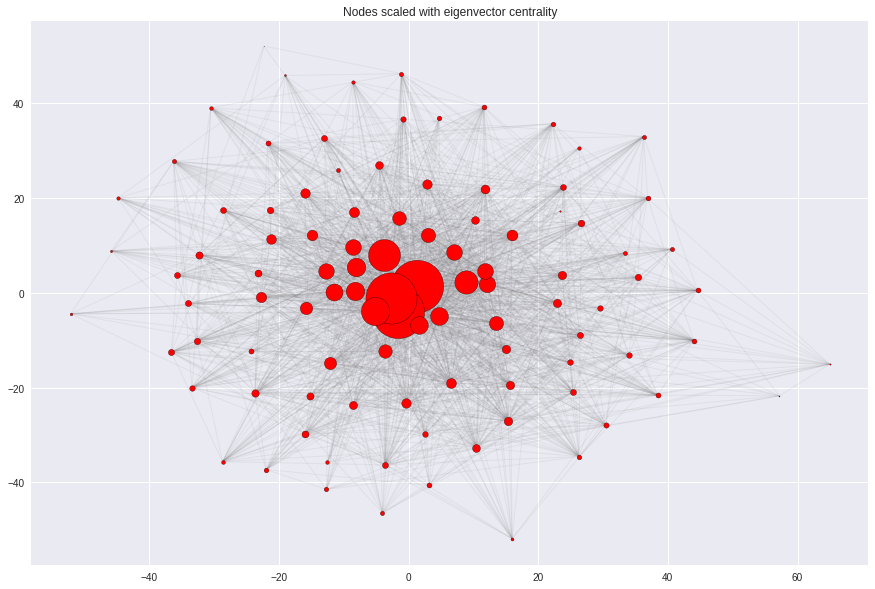

In [0]:
centrality = nx.eigenvector_centrality(G, weight='weight')

plt.figure(figsize=(15,10))
scale_rate = 5000

for node in G.nodes():
    nx.draw_networkx_nodes(G, pos, [node], 
                         node_size=scale_rate * centrality[node],
                         edgecolors="black",
                         cmap=plt.cm.jet, vmin=0.0, vmax=1.0)

nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color="gray")
plt.title("Nodes scaled with eigenvector centrality")
plt.show()

The eigenvector centrality takes the weighted degree into considerations. This, along with the fact that most characters are well-connected, means the centrality measure mirrors the weighted degree proportions.

## Community detection

In [0]:
!pip install python-louvain
import community

  Running setup.py bdist_wheel for python-louvain ... - done
  Stored in directory: /root/.cache/pip/wheels/c3/b0/db/198c7453d5169907dbdbb090eebc0c6839f75e36b09c6dc7aa
Successfully built python-louvain


In [0]:
partition = community.best_partition( G )
community.modularity(partition, G)

0.15565056308588215

This is a low score, indication that the network is not easily split into different communities. Many of the characters have a high interaction reach.

### Plot communities

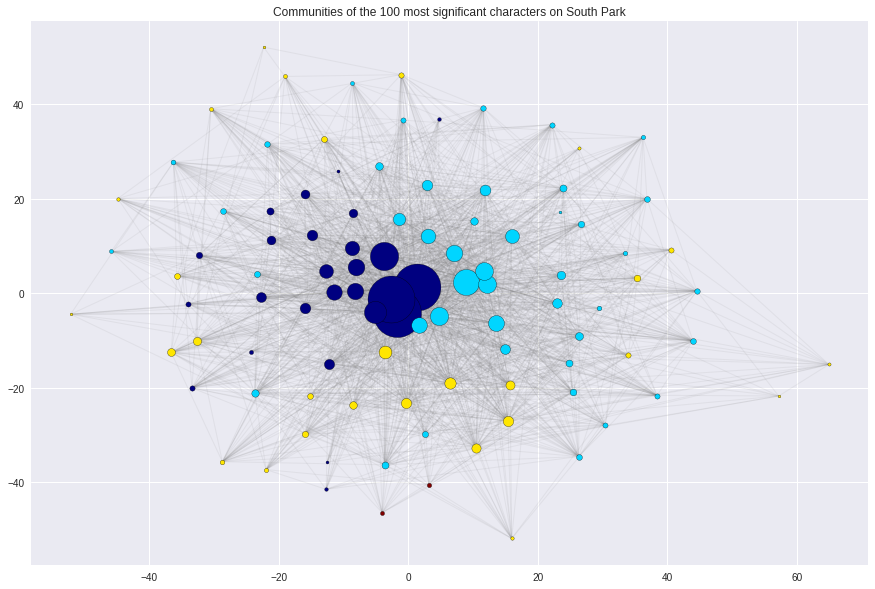

In [0]:
plt.figure(figsize=(15,10))

communities = set(partition.values())
color_map = np.linspace(0,1, len(communities))
scale_rate = 0.3

for node in G.nodes():
    node_color = color_map[ partition[node] ]
    nx.draw_networkx_nodes(G, pos, [node], 
                         node_size=scale_rate*G.degree(node, weight='weight'),
                         node_color=[ node_color ],
                         edgecolors="black",
                         cmap=plt.cm.jet, vmin=0.0, vmax=1.0)

nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color="gray")
plt.title("Communities of the 100 most significant characters on South Park")
plt.show()

With a low modularity score, the communities detected will not be perfect. Most, if not all characters, will fit into different groups/communities - e.g. Stan has a group with Kyle and Cartman, with the kids of the town (including Kyle and Cartman again) and his family (just to name a few). A different community algorithm, like link clustering, could reveal this.

But it is clear from the plot, that the 3 main characters (the 3 nodes in the center) are in the same community. Which they should be.

In [0]:
[ n for n in G.nodes() if partition[n] == 0 ]

['Kyle',
 'Stan',
 'Cartman',
 'Butters',
 'Kenny',
 'Clyde',
 'Craig',
 'Jimmy',
 'Wendy',
 'Token',
 'Ike',
 'Heidi',
 'Tweek',
 'The Boys',
 'Bebe',
 'Timmy',
 'Kids',
 'Pip',
 'Red',
 'Towelie',
 'Cartman as Jennifer Lopez',
 'Driver',
 'Ms. Crabtree',
 'Kyle Two',
 'Receptionist',
 'General Deckter']

<table><tr><td>!!!</td></tr></table>

It appears one group consists mainly of the kids from the same class as Stan, Kyle and Cartman. Which is a reasonable split, if a character can only belong to one group.

# Changes through the seasons

## Find top 5 characters in dialog volume, interaction strength/reach, centrality (+ network modularity)

### Find all values in one big loop and create dataframes

In [0]:
## Helper function
# try adding position to char in season
# if that char hasn't appeared before
# create 21 long list with NaNs, fill the current season with position
def try_assignment(i, season, char_dict, char):
    try:
        char_dict[char][season-1] = i+1
    except:
        char_dict[char] = [np.nan] * 21
        char_dict[char][season-1] = i+1

        
season_modularities = [] # modularity of network from each season

# key: character, value: list of rank in top 5 (21 long, with possible NaNs)
char_inter_weight = {}
char_inter_unweight = {}
char_cnt = {}
char_dialog_vol = {}

# find top 5 characters for different measurements for each season 
# and season network modularity
for season in range(1,21+1):
    # links and their weight
    val_count = df_interact.loc[ df_interact['season'] == season ]['interaction'].value_counts()
    links = val_count.index.tolist()
    weights = val_count.tolist()

    # Add links to undirected network
    G = nx.Graph()
    for i, link in enumerate(links):
        G.add_edge(link[0], link[1], weight=weights[i])
    
    # find community modularity
    partition = community.best_partition( G )
    season_modularities.append( (season, community.modularity(partition, G)) )
    
    # find top 5 characters for: 
    #    centrality, weighted and un-weighted interactions, dialog
    centrality = nx.eigenvector_centrality(G)
    top5_cnt, _ = zip(* sorted(centrality.items(), key=lambda x: x[1], reverse=True )[:5])
    top5_weight, _ = zip(* sorted(G.degree(G.nodes(), weight='weight'), key=lambda x: x[1], reverse=True)[:5]  )
    top5_unweight, _ = zip(* sorted(G.degree(G.nodes()), key=lambda x: x[1], reverse=True)[:5]  )
    top5_dialog = df_dialog.loc[ df_dialog.season == season ].character.value_counts()[:5].index
    
    for i in range(5):
        try_assignment(i, season, char_cnt,            top5_cnt[i])
        try_assignment(i, season, char_inter_weight,   top5_weight[i])
        try_assignment(i, season, char_inter_unweight, top5_unweight[i])
        try_assignment(i, season, char_dialog_vol,     top5_dialog[i])
        


## Create dataframes

# modularity
df_modularity = pd.DataFrame(season_modularities, columns=['season', 'modularity'])
df_modularity.set_index('season', inplace=True)

# centrality
df_centrality = pd.DataFrame(char_cnt)
df_centrality['season'] = range(1,21+1)
df_centrality.set_index('season', inplace=True)

# weighted interactions
df_interact_weight = pd.DataFrame(char_inter_weight)
df_interact_weight['season'] = range(1,21+1)
df_interact_weight.set_index('season', inplace=True)

# un-weighted interactions
df_interact_unweight = pd.DataFrame(char_inter_unweight)
df_interact_unweight['season'] = range(1,21+1)
df_interact_unweight.set_index('season', inplace=True)

# dialog
df_dialog_vol = pd.DataFrame(char_dialog_vol)
df_dialog_vol['season'] = range(1,21+1)
df_dialog_vol.set_index('season', inplace=True)


### Dialog volume per season

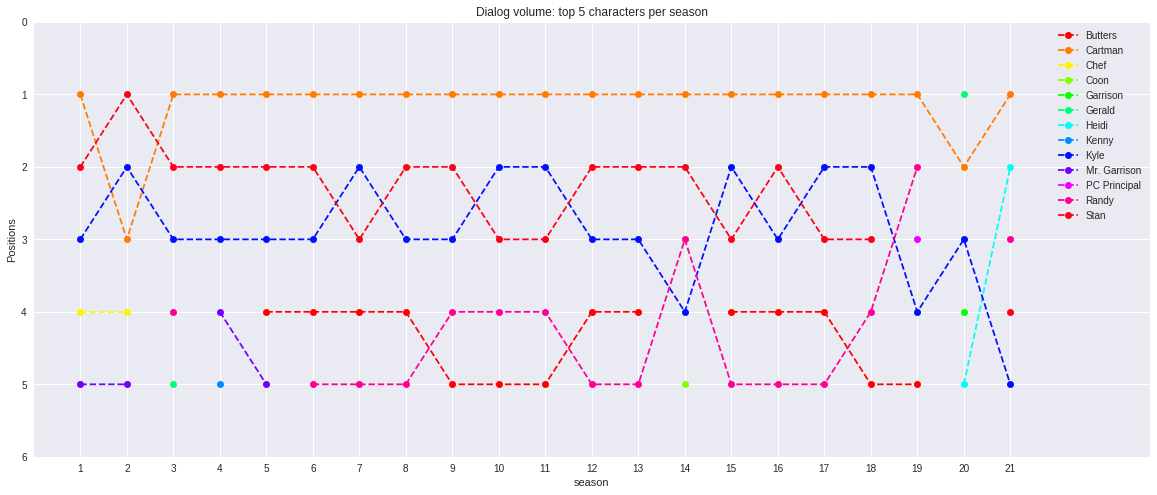

In [0]:
df_dialog_vol.plot(style='--o', xticks=range(1,21+1), figsize=(20,8), colormap='hsv')
plt.ylim((0,6))
plt.xlim((0,24))
plt.ylabel('rank')
plt.title('Dialog volume: top 5 characters per season')
plt.gca().invert_yaxis()
plt.show()

Up until season 14 there is a clear trend with Cartman in the lead and Kyle and Stan fighting for 2nd place. Different supporting characters take up the last two spots. But from season 14 and especially the last 3, the pattern changes. The first spot is taken by a non-main character, Gerald, and Kyle and Stan leave the top 3.
Clearly the show wanted to change it up, with a lot of stories focusing on the supporting cast, but Cartman remains the voice of South Park.

### Interaction strengths (weighted degree) per season

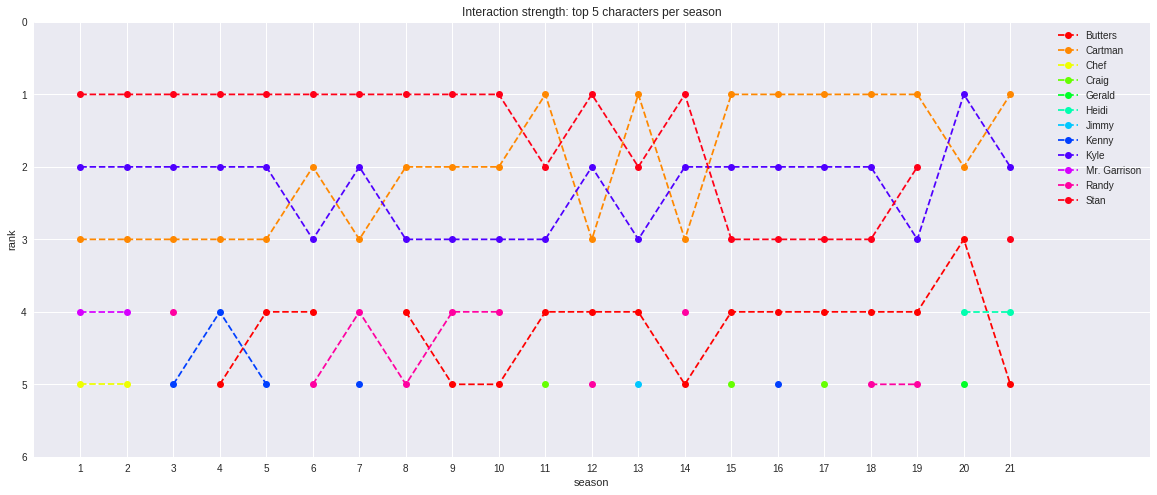

In [0]:
df_interact_weight.plot(style='--o', xticks=range(1,21+1), figsize=(20,8), colormap='hsv') # colormap = hsv, tab20
plt.ylim((0,6))
plt.xlim((0,24))
plt.gca().invert_yaxis()
plt.ylabel('rank')
plt.title('Interaction strength: top 5 characters per season')
plt.show()

This shows who has had the most interactions with other characters per season.  
Cartman, Stan and Kyle fight over the top 3 spots through out all seasons, with several supporting characters vying for the remaning top spots. Only exception is season 20, where Stan is replaced by Butters in top 3.

### Interaction reach (unweighted degree) per season

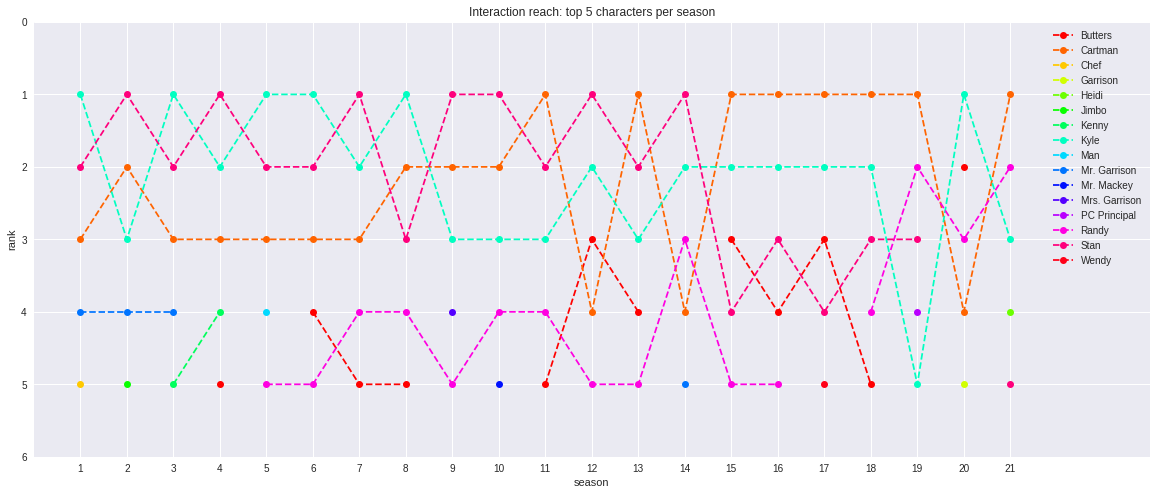

In [0]:
df_interact_unweight.plot(style='--o', xticks=range(1,21+1), figsize=(20,8), colormap='hsv') # colormap = hsv, tab20
plt.ylim((0,6))
plt.xlim((0,24))
plt.gca().invert_yaxis()
plt.ylabel('rank')
plt.title('Interaction reach: top 5 characters per season')
plt.show()

This shows who has had the greatest reach - interacted with as many different characters as possible - per season.  
Cartman, Stan and Kyle are still in top 3 for the majority of the seasons. But from season 19 and on, some supporting characters begin to move into the top 3 - namely Randy and Butters.

### Eigenvector centrality

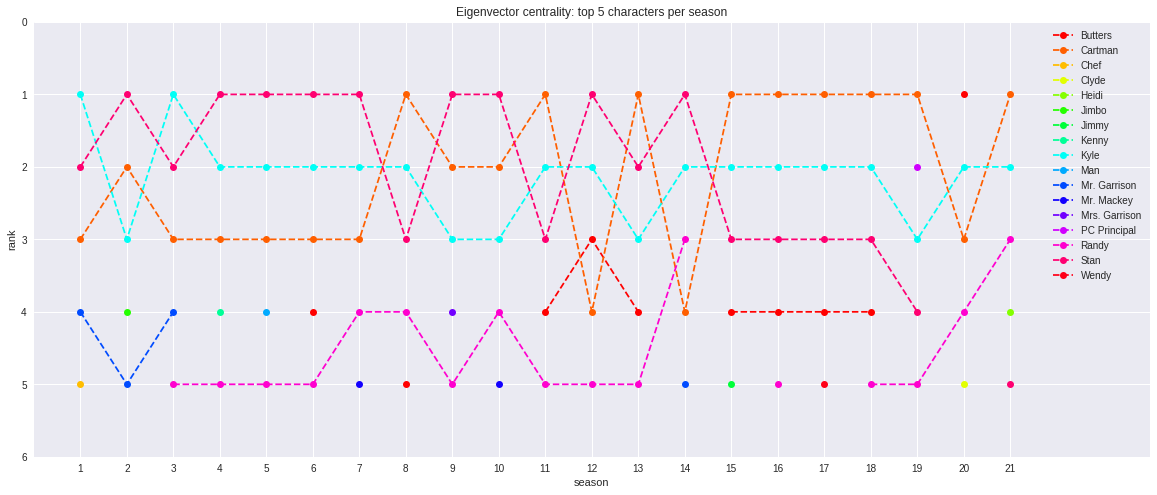

In [0]:
df_centrality.plot(style='--o', xticks=range(1,21+1), figsize=(20,8), colormap='hsv') # colormap = hsv, tab20
plt.ylim((0,6))
plt.xlim((0,24))
plt.gca().invert_yaxis()
plt.ylabel('rank')
plt.title('Eigenvector centrality: top 5 characters per season')
plt.show()

This shows who has been the most central characters per season.  
The trend from the two previous plots remain: Cartman, Stan and Kyle in top 3 up until season 19, where other characters become more central. It is Randy and Butters again, including PC Principal in season 19, where he makes his first appearence on the show.

### Modularity

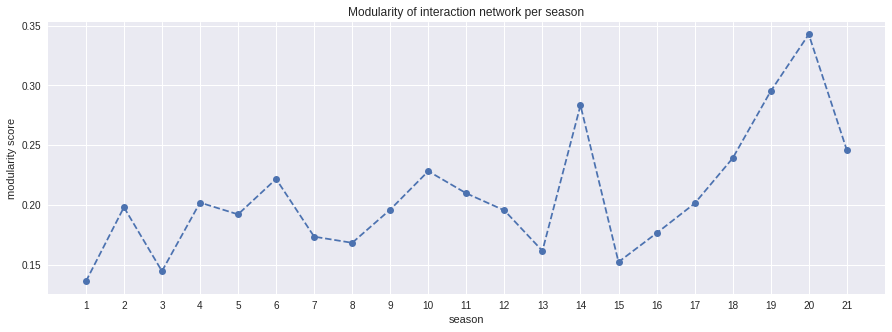

In [0]:
df_modularity.plot(xticks=range(1,21+1), figsize=(15,5), style='--o', legend=False)
plt.ylabel('modularity score')
plt.title('Modularity of interaction network per season')
plt.show()


There is a clear upwards trend, meaning the interaction networks are becoming easier to partition into communities. This could be a result of more self-contained side stories, where the characters don't interact as much with each other.

### Concluding on the dialog and network of interactions

From all the plots of dialog, interaction strength and reach, centrality and modularity, it seems something has changed from season 19 and on. 

This change is best exemplified by Gerald (the father of Kyle), who features heavily in season 20 and is the character with the most dialog in that season. He comes in 5th in interaction stength (weighted), but is neither in top 5 for interaction reach (unweighted) nor centrality.  
I.e. he has a lot of dialog in general, quite a bit together with other characters, but not with a wide range of the 100 most significant characters. This would also support the trend in modularity, where characters with isolated side stories could explain the increase.

## Analyze sentiment of characters through seasons

### Tokenize all dialog

In [0]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Define excludes - list of words and characters to exclude
from nltk.corpus import stopwords
import string
english_stopwords = stopwords.words('english')
excludes = english_stopwords
excludes += string.punctuation
excludes += ["''", "``", "'s", "’", "…", "..."] # special characters

# create new column in dataframe for tokens of each dialog
tokenizer = lambda dialog: [t.lower() for t in nltk.word_tokenize( dialog ) if t not in excludes]
df_dialog['tokens'] = df_dialog.dialog.apply(tokenizer)    

In [0]:
df_dialog.head()

season character                                             dialog  \
3       1      Kyle            Ike, you can't come to school with me.    
5       1      Kyle               Dude, don't call my brother a dildo!   
7       1      Kyle  Well, I don't know... and I'll bet Cartman doe...   
8       1   Cartman                              I know what it means!   
9       1      Kyle                                        Well, what?   

                                              tokens  
3                       [ike, ca, n't, come, school]  
5                  [dude, n't, call, brother, dildo]  
7  [well, i, n't, know, i, 'll, bet, cartman, n't...  
8                                   [i, know, means]  
9                                             [well]

### Sentiment analysis

Formula for average happiness of a text:
$$ h_{avg}(T) = \sum_{i=1}^{N} h_{avg}(w_i)p_i $$

In [0]:
# Read csv file containing happiness score for word collection
df_happiness = pd.read_csv(data_path + "LabMTwordlist.txt", sep="\t")

# Get words as set, for later use
wordlist_words = set( df_happiness["word"] )

# Create dictionary with words as keys and happiness_average as values
# I found this to be much faster than looking up the value directly in the dataframe
word_happiness = {}
for w in wordlist_words:
    word_happiness[w] = df_happiness.loc[df_happiness['word'] == w]["happiness_average"].tolist()[0]

In [0]:
def text_sentiment(list_tokens):
    # only use tokens that have a happiness score
    tokens_with_happiness = set(list_tokens).intersection( wordlist_words )
    tokens = [t for t in list_tokens if t in tokens_with_happiness]

    # Find frequency and happiness_avg of each valid token
    fq_dist = nltk.FreqDist( tokens )
    freqs = list(fq_dist.values())
    tokens_avg_happiness = list(map(lambda token: word_happiness[token], tokens))

    # Calculate: h_avg(wi) * pi, where pi = fi / sum_all_freqs
    # Sum over all the values
    h_avg_and_freq = zip(tokens_avg_happiness, freqs)
    h_avg_text = sum(map(lambda x: x[0] * x[1] / sum(freqs), h_avg_and_freq ))
    score = round(h_avg_text, 2) if h_avg_text > 0.0 else 5.0 # return mean, 5.0, if 0.0
    return score


In [0]:
# Test the function
positive_list = "happy love joy laughter smiling sunshine pleasure".split(" ")
negative_list = "pain murder rape dead decay torture rotting".split(" ")

print("Positive list:", text_sentiment(positive_list) )
print("Negative list:", text_sentiment(negative_list) )

Positive list: 8.14
Negative list: 2.1


In [0]:
# Add new column of sentiments from tokens
sentimenter = lambda tokens: text_sentiment(tokens)
df_dialog['sentiment'] = df_dialog.tokens.apply( sentimenter )

df_dialog.head()

season character                                             dialog  \
3       1      Kyle            Ike, you can't come to school with me.    
5       1      Kyle               Dude, don't call my brother a dildo!   
7       1      Kyle  Well, I don't know... and I'll bet Cartman doe...   
8       1   Cartman                              I know what it means!   
9       1      Kyle                                        Well, what?   

                                              tokens  sentiment  
3                       [ike, ca, n't, come, school]       5.73  
5                  [dude, n't, call, brother, dildo]       6.25  
7  [well, i, n't, know, i, 'll, bet, cartman, n't...       5.98  
8                                   [i, know, means]       5.89  
9                                             [well]       6.68

### Sentiment distributions of main characters

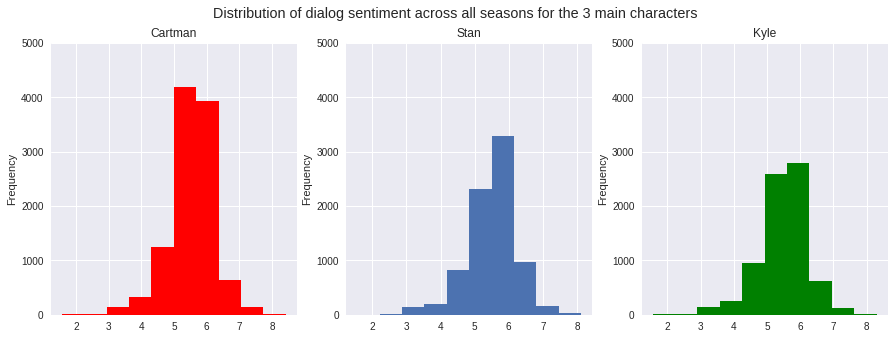

In [0]:
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of dialog sentiment across all seasons for the 3 main characters')

plt.subplot(1,3,1)
plt.ylim(0,5000)
plt.title('Cartman')
df_dialog.loc[ (df_dialog.character == 'Cartman')].sentiment.plot(kind='hist', color='red')

plt.subplot(1,3,2)
plt.ylim(0,5000)
plt.title('Stan')
df_dialog.loc[ (df_dialog.character == 'Stan')].sentiment.plot(kind='hist')

plt.subplot(1,3,3)
plt.ylim(0,5000)
plt.title('Kyle')
df_dialog.loc[ (df_dialog.character == 'Kyle')].sentiment.plot(kind='hist', color='green')


plt.show()

There is no clear difference between them. Which might not be that surprising giving that a lot of dialog is descriptive and neutrally informative.

### Sentiment values for all characters per season

In [0]:
mean_std = pd.DataFrame()
mean_std['means'] = df_dialog.groupby(['season'])['sentiment'].mean()
mean_std['stds'] = df_dialog.groupby(['season'])['sentiment'].std()

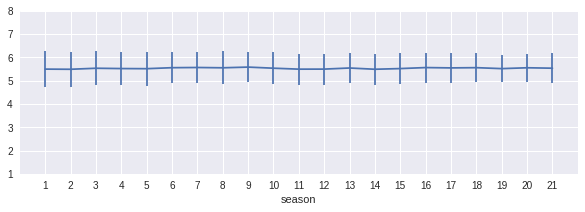

In [0]:
mean_std.means.plot(
    yerr=mean_std.stds, 
    ylim=(1,8), 
    xticks=range(1,21+1), 
    figsize=(10,3)
)

The mean sentiment of all characters in each season does not hold any useful information.

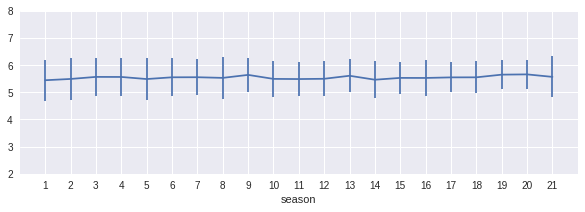

In [0]:
cartman_sentiment = pd.DataFrame()
cartman_sentiment['means'] = df_dialog.loc[ df_dialog.character == 'Cartman'].groupby(['season'])['sentiment'].mean()
cartman_sentiment['stds'] = df_dialog.loc[ df_dialog.character == 'Cartman'].groupby(['season'])['sentiment'].std()
cartman_sentiment['means'].plot( yerr=cartman_sentiment['stds'], ylim=(2,8), xticks=range(1,21+1), figsize=(10,3) )

Even someone like Cartman, known for his foul language, hasn't got any significant changes to his season sentiments.  

It seems fair to conclude that mean sentiment scores of dialog isn't a useful metric for analyzing changes in seasons.  
Maybe a list of profanities (cuss/swear words) or a LIX count might have revealed something more interesting.

## Unique words in episode synopses

### Tokenize

In [0]:
# Add new column of tokenized synopses
tokenizer = lambda synopsis: [t.lower() for t in nltk.word_tokenize(synopsis) if t not in excludes]
df_synopses['tokens'] = df_synopses['synopsis'].apply(tokenizer)

df_synopses.head()

season                                           synopsis  \
0       1  While the boys are waiting for the school bus,...   
1       1  Cartman "wins" an essay contest and Kathie Lee...   
2       1  The boys go on a hunting trip with Stan Marsh'...   
3       1  Stan's new dog, Sparky, comes across as potent...   
4       1  Kyle's mom won't let him keep his new pet, an ...   

                                              tokens  
0  [while, boys, waiting, school, bus, eric, cart...  
1  [cartman, wins, essay, contest, kathie, lee, g...  
2  [the, boys, go, hunting, trip, stan, marsh, un...  
3  [stan, new, dog, sparky, comes, across, potent...  
4  [kyle, mom, wo, n't, let, keep, new, pet, elep...

### Calculate tf-idf values for all tokens

#### Define word frequency distributions for all seasons

In [0]:
# frequency distribution for each season
season_fq_dist = {}

for season in range(1,21+1):
    all_synopses = df_synopses.loc[ df_synopses.season == season ]['tokens'].tolist()
    flatten = [token for synopsis in all_synopses for token in synopsis]
    season_fq_dist[season] = nltk.FreqDist( flatten )

#### Define tf-idf

In [0]:
import math
def tf(term, document):
    return season_fq_dist[document][term]

def idf(term, corpus):
    N = len(corpus)
    return math.log( N / len([d for d in corpus if term in d]) )

def tf_idf(term, document, corpus):
    return tf(term, document) * idf(term, corpus)


#### Calculate tf-idf values

In [0]:
# tf-idf scores for each term in all synopses per season
season_synopses_tfidf = {}

# Each document in the corpus, is the tokens from all synopses per season
list_flattener = lambda synopses: [token for synopsis in synopses for token in synopsis ]
corpus = df_synopses.groupby(['season'])['tokens'].apply( list_flattener ).tolist()

# for each season (document), calculate the tf-idf scores of its tokens
for season in range(1,21+1):
    for unique_term in season_fq_dist[season].keys():
        tf_idf_val = tf_idf(unique_term, season, corpus)
        try:
            season_synopses_tfidf[season][unique_term] = tf_idf_val
        except:
            season_synopses_tfidf[season] = {unique_term: tf_idf_val}
        

In [0]:
season = 21
print('Words with highest tf-idf scores for season {0}'.format(season))
sorted(season_synopses_tfidf[season].items(), key=lambda x: x[1], reverse=True)[:10]

Words with highest tf-idf scores for season 21


[('witch', 6.089044875446846),
 ('relationship', 4.702750514326955),
 ('white', 3.8918202981106265),
 ('middle', 3.316456153207065),
 ('grips', 3.044522437723423),
 ('today', 3.044522437723423),
 ('petty', 3.044522437723423),
 ('conflict', 3.044522437723423),
 ('drives', 3.044522437723423),
 ('brink', 3.044522437723423)]

### Create wordclouds for each season

In [0]:
!pip install wordcloud
from wordcloud import WordCloud

    100% |████████████████████████████████| 368kB 5.4MB/s 


#### Wordclouds for the most frequent terms (NOT tf-idf scores)

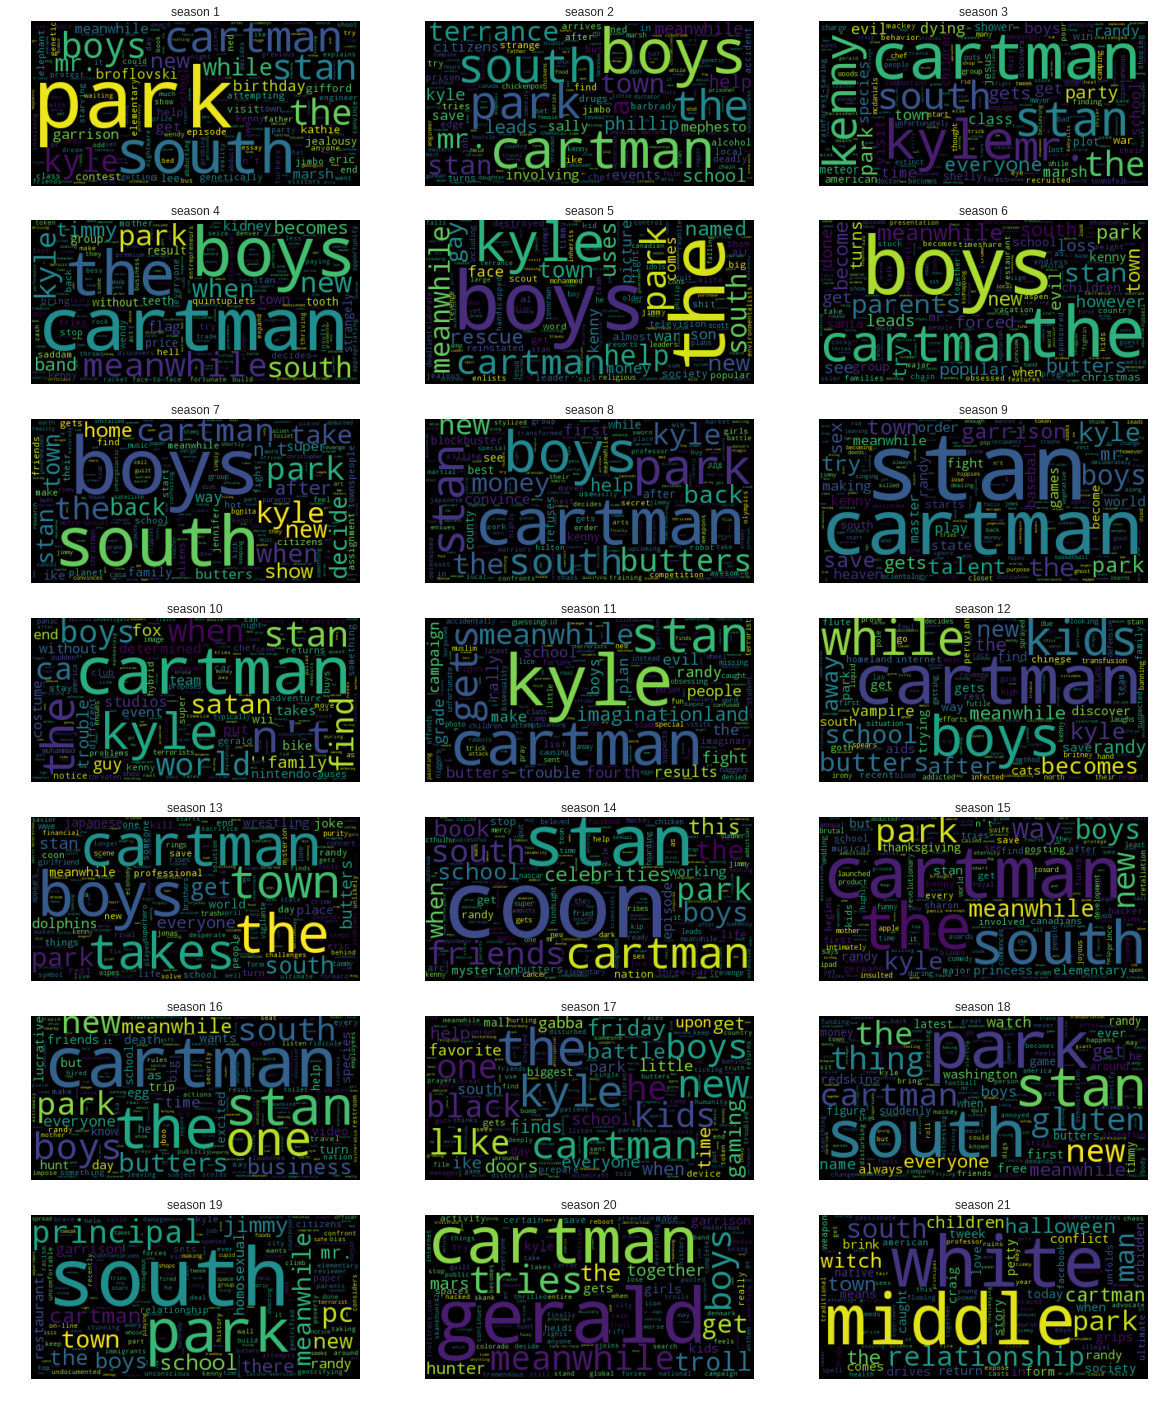

In [0]:
plt.figure(figsize=(20,25))

for season in range(1,21+1):
    wordcloud = WordCloud().generate_from_frequencies( season_fq_dist[season] )

    plt.subplot(7, 3, season)
    plt.axis('off')
    plt.title('season ' + str(season))
    plt.imshow(wordcloud, interpolation='bilinear')
    
plt.show()
    

From season 1 to 19 the most frequent words are very generic ones: south, park, cartman, stan, kyle, boys, town. This is not surprising, since those terms are the most central to the show - with the first two being the name of the show and the town that the show is set in.
But season 20 and 21 clearly stand out. Gerald is the most frequent in season 20, and "white" and "middle" for season 21. It is not possible to say too much from this, given that the synopses are very short. Additionally, they are authored by fans (most likely many different ones) and perhaps after 19 seasons, they felt it less necessary to repeat the name of the town/show frequently. But they stand out none the less.

#### Wordclouds from terms with highest tf-idf scores

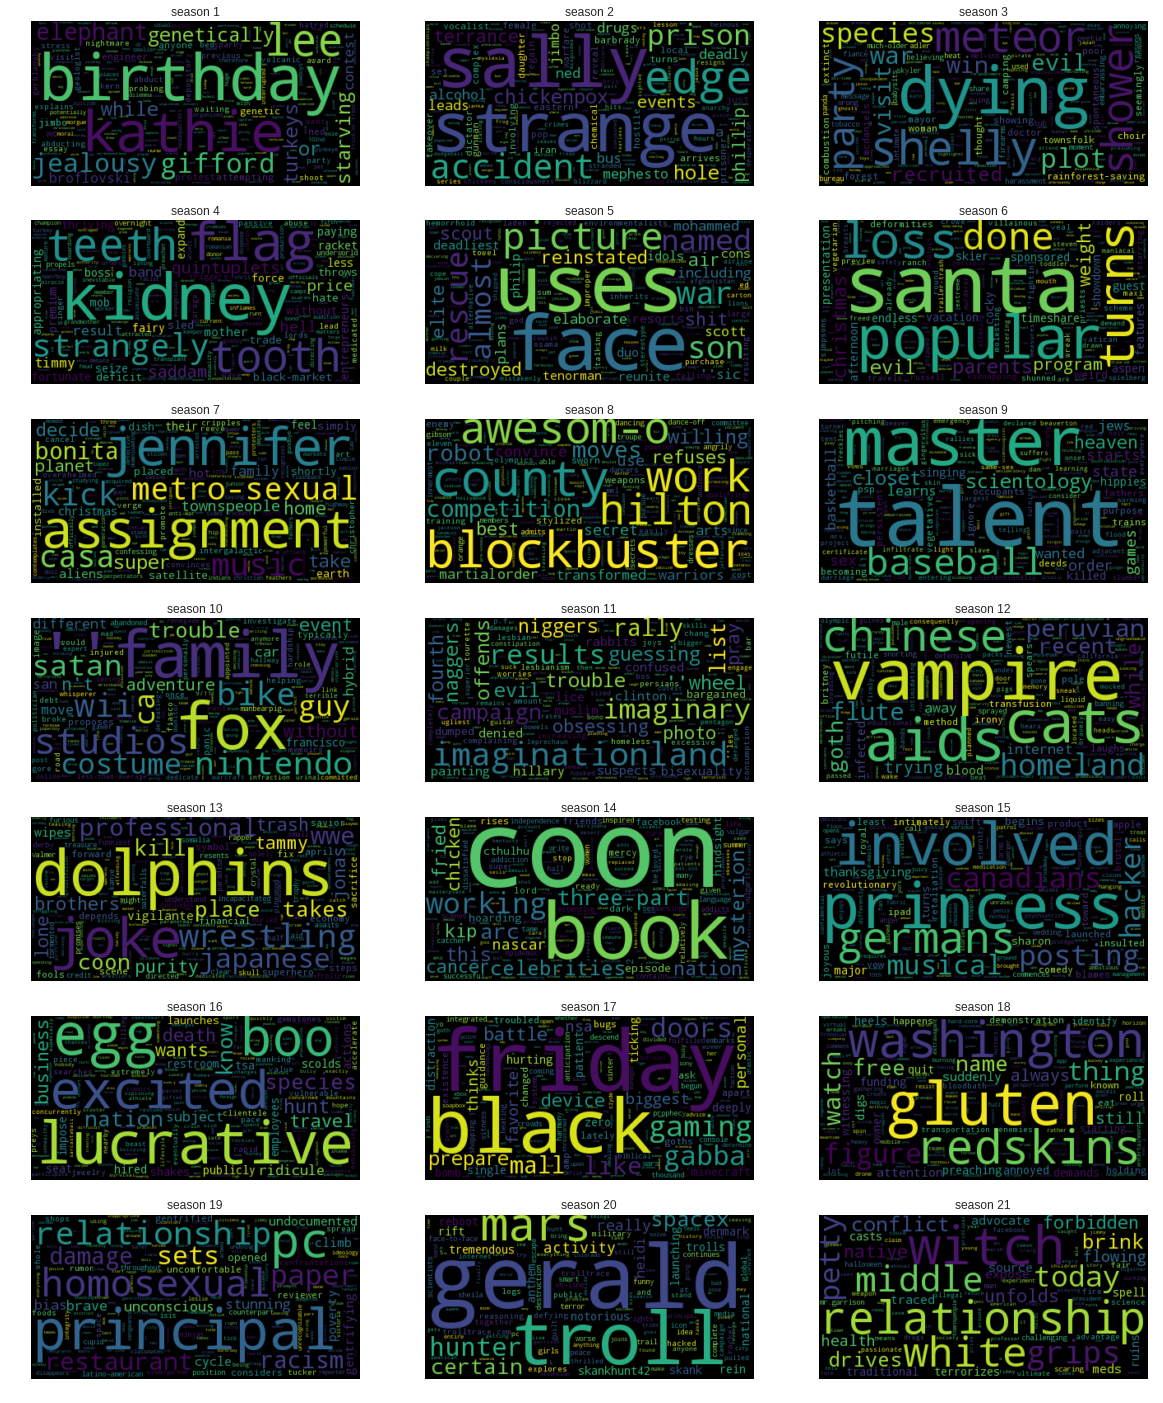

In [0]:
plt.figure(figsize=(20,25))

for season in range(1,21+1):
    wordcloud = WordCloud().generate_from_frequencies( season_synopses_tfidf[season] )

    plt.subplot(7, 3, season)
    plt.axis('off')
    plt.title('season ' + str(season))
    plt.imshow(wordcloud, interpolation='bilinear')
    
plt.show()
    

Creating wordclouds from the terms with the highest tf-idf scores, results in season theme descriptions. It is difficult see any trends in the kinds of themes throughout the seasons - other than that they are very varied.  
But season 20 and 21 stand out as some of their terms with the highest tf-idf scores are also their most frequent terms (unlike the other seasons).

## Any correlation with the highest rated seasons

The average rating of each season is based on IMDb user ratings, collected from www.ratingraph.com.

In [0]:
df_rating = pd.read_csv(data_path + 'south_park_season_ratings.txt', sep='\n', delimiter=',')
df_rating.set_index('season', inplace=True)

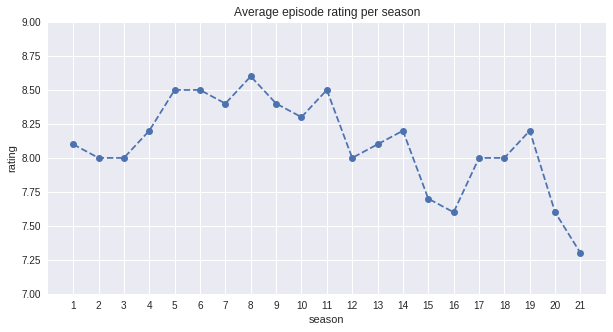

In [0]:
df_rating.plot(style='--o', xticks=range(1,21+1), figsize=(15,5), legend=False)
plt.ylim((7,9))
plt.xlim((0,22))
plt.ylabel('rating')
plt.title("Average episode rating per season")
plt.show()

A lot of different factors affect the rating of an episode and ultimately the rating of a season. It is very unlikely that the factors looked at in this notebook is enough to explain the rating trend in great detail.  
However, season 20 and 21 are the lowest rated seasons of South Park. And season 19, although a local maximum, is part of the lower half of seasons overall. And these last three seasons are the ones that have stood out in the analyses in this notebook. This is where South Park has experimented with new formats for the show - with a greater focus on side stories featuring supporting characters (like Gerald and Randy), recurrent themes throughout a season and multi-part episodes.

These changes are what has been picked up in these analyses, using basic network science and text processing. 

The creators of South Park has stated that they want to return to the standalone episodes format, that South Park has utilized predominantely. That might just be what South Park needs.